In [2]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt
from datapipe import bin_ndarray, calcDff
import importlib
%load_ext autoreload
%autoreload 2
from scipy import interpolate

#TODO: read tf documentation on what the static_rnn does
#do I want to one hot encode the data? or already too many dimensions

In [3]:
# #open files, they have not been normalized yet
# dffile = open('masdfr4m7170321s1.pkl',"rb")
# dyfile = open('r4m7170321s1.pkl', "rb")
# df = pickle.load(dffile)
# df = df.drop(columns='pupilCurr', axis=1)
# df = df.drop(columns='pupilPeri', axis=1)
# df = df[["stimType", "intensity", "wheelPeri", 'responseT','response','whiskPeri', 'lastStimT', 'pupilMovement', 'vidPeri']]
# df = df.interpolate()
# dy = pickle.load(dyfile)
# print(df)
# df["YY"] = np.arange(0, len(df))
# df = df.dropna(0)
# y = np.empty((len(df), 22360))
# y_index = 0
# for ind in df["YY"]:
#     y[y_index] = dy[ind]
#     y_index+=1

# xdf  = df.drop("YY", axis=1)


In [4]:
def bin_dy(dy):
    (length, y, x) = dy.shape
    print(dy.shape)
    newdy = np.zeros((length, int(y/2), int(x/2)), dtype=np.float32)
    for ind, image in enumerate(dy):
        newdy[ind] = bin_ndarray(image, (int(y/2), int(x/2)))
    # newdyfile = open('./dfy/bin_AV_2.pkl', 'wb')
    print(newdy.shape)
    return newdy

In [5]:
def process_dy(dy):
    (length, y, x) = dy.shape
    newdy = np.zeros((length, y-40, x-50), dtype=np.float32)
    for ind, image in enumerate(dy):
        newimg = image[1:-39, 0:-50]
        newdy[ind] = image[1:-39, 0:-50]
    print(newdy[0].shape)
    return bin_dy(newdy)
    # newdyfile = open('./dfy/cropped_AV_2.pkl', 'wb')
#     np.save('./data/cropped_AV_5.npy', newdy)

In [8]:
#loading full file on disk, can access small slices without loading into memory
fdy = np.load('./data/dffAV_2.npy', mmap_mode='r')
# fdy = process_dy(fdy)
print("dff")
# fdy = calcDff(fdy, .2, 30)
f = open('./data/masdfAV_2.pkl', 'rb')
df = pickle.load(f)
(length, y, x) = fdy.shape

dff


In [9]:
print(length,y,x)

52478 300 295


In [10]:
fdy = np.ndarray.astype(fdy, np.float16)
np.save('./data/dffAV_2.npy', fdy)


In [11]:
fdy = np.ndarray.astype(fdy, np.float32)

In [30]:
np.interp([1,2,3,4,5], [1,3,5],[100,900,111])

array([100. , 500. , 900. , 505.5, 111. ])

In [12]:
dy_test =fdy[9000:10000]
# dy_test = process_dy(dy_test)
(length, leny, lenx) = dy_test.shape
dy_test = dy_test.reshape(length, leny*lenx)
df_test = df[9000:10000]
df_test = df_test[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]

In [13]:
#interpolate to 30 hz
def interpolate_vid(vid, num):
    #need to go through the dimensions of the photo and get all instances and interpolation
    (length, x, y) = vid.shape
    interpVid = np.zeros((length*num, x,y),dtype=np.float16)
    x1 = np.linspace(1, (length*num-length), length)
    newX = np.linspace(1, (length*num-length), (length*num-length))
#     newX = np.sort(np.append(newX,x1))
    print(x1)
    print(newX)
    for i in range(int(y)):
        for j in range(int(x)):
            tempArr = np.zeros(length*num, dtype=np.float16)
            newData = np.interp(newX, x1, vid[:,j,i])
            realInd = 0
            vidInd = 0
            for itemInd, item in enumerate(newData):
                if itemInd % (num-1) == 0 or itemInd==0:
                    if itemInd ==0 or itemInd==(length-1):
                        tempArr[realInd] = vid[vidInd,j, i]
                        realInd +=1
                        vidInd +=1
                    else:
                        tempArr[realInd] = vid[vidInd, j, i]
                        tempArr[realInd+1] = item
                        realInd +=2
                        vidInd +=1
                else:
                    tempArr[realInd] = item
                    realInd +=1
            interpVid[:,j,i] = tempArr
    return interpVid

In [14]:
def interpolate_df(df, num):
    #need to go through the dimensions of the photo and get all instances and interpolation
    (length, x) = df.shape
    interpVid = np.zeros((length*num, x),dtype=np.float16)
    x1 = np.linspace(1, length*num, length)
    newX = np.linspace(1, length*num, (length*num-length))
#     newX = np.sort(np.append(newX,x1))
    print(len(x1))
    print(len(newX))
    print(df[:,3])
    for i in range(int(x)):
        tempArr = np.zeros(length*num, dtype=np.float16)
        newData = np.interp(newX, x1, df[:,i])
        realInd = 0
        vidInd = 0
        print(newData)
        print(df[:,i])
        for itemInd, item in enumerate(newData):
            if itemInd % (num-1) == 0 or itemInd==0:
                if itemInd ==0 or itemInd==(length-1):
                    tempArr[realInd] = df[vidInd, i]
                    realInd +=1
                    vidInd +=1
                else:
                    tempArr[realInd] = df[vidInd, i]
                    tempArr[realInd+1] = item
                    realInd +=2
                    vidInd +=1
            else:
                tempArr[realInd] = item
                realInd +=1
        print(realInd)
        tempArr[-1] = df[-1, i]
        interpVid[:,i] = tempArr
    return interpVid

In [85]:
#1hz data
dfcropped = (df.iloc[::30])
dfcropped = dfcropped[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]

dycropped= (fdy[::30])

# dycropped = process_dy(dycropped)


In [71]:
onehzInterp = interpolate_vid(dycropped, 5)

[1.00000000e+00 5.00171527e+00 9.00343053e+00 ... 6.99199657e+03
 6.99599828e+03 7.00000000e+03]
[1.000e+00 2.000e+00 3.000e+00 ... 6.998e+03 6.999e+03 7.000e+03]


In [86]:
dfInterp = interpolate_df(dfcropped.values, 5)
dfInterp = pd.DataFrame(data=dfInterp, columns=dfcropped.columns)
dfcropped = dfInterp
dycropped = onehzInterp

1750
7000
[0.         1.6422528  1.7069509  ... 3.8784008  3.78591561 2.57846713]
[-1. -1. -1. ...  0.  0.  0.]
[-1. -1. -1. ...  0.  0.  0.]
8749
[0.17486572 0.16872669 0.16258766 ... 0.16968185 0.17448631 0.17929077]
[0.17486572 0.15029907 0.15335083 ... 0.15731812 0.1600647  0.17929077]
8749
[0.         0.23055301 0.46110601 ... 1.41055598 1.26644303 1.12233007]
[0.         0.92260748 1.24299586 ... 2.00665736 1.69902909 1.12233007]
8749
[0.         0.41038722 0.82077444 ... 3.1819326  2.88019986 2.57846713]
[0.         1.6422528  1.7069509  ... 3.8784008  3.78591561 2.57846713]
8749
[3.00216675 3.00224301 3.00231927 ... 3.00247179 3.00231927 3.00216675]
[3.00216675 3.00247192 3.00201416 ... 3.00216675 3.0027771  3.00216675]
8749
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
8749
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
8749
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
8749
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
8749
[0. 0. 0. ... 1. 1. 1.]
[0. 0. 0. ... 1. 1. 1

In [62]:
print(dfInterp)

      stimType  pupilCurr  snoutCurr   jawCurr  wheelCurr  responseT    H  \
0         -1.0   0.174805   0.000000  0.000000   3.001953        0.0  0.0   
1         -1.0   0.168701   0.230591  0.410400   3.001953        0.0  0.0   
2         -1.0   0.162598   0.461182  0.820801   3.001953        0.0  0.0   
3         -1.0   0.156494   0.691895  1.231445   3.001953        0.0  0.0   
4         -1.0   0.150269   0.922852  1.642578   3.001953        0.0  0.0   
5         -1.0   0.150269   0.922363  1.641602   3.001953        0.0  0.0   
6         -1.0   0.151001   1.002930  1.658203   3.001953        0.0  0.0   
7         -1.0   0.151855   1.083008  1.674805   3.001953        0.0  0.0   
8         -1.0   0.152588   1.163086  1.690430   3.001953        0.0  0.0   
9         -1.0   0.153320   1.243164  1.707031   3.001953        0.0  0.0   
10        -1.0   0.153320   1.243164  1.707031   3.001953        0.0  0.0   
11        -1.0   0.155640   1.140625  1.723633   3.001953        0.0  0.0   

In [101]:
#5hz data
dfcropped = (df.iloc[::6])
dfcropped = dfcropped[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]

dycropped= (fdy[::6])
print("finisheddff")
# dycropped = process_dy(dycropped)

finisheddff


In [16]:
#10hz data
dfcropped = (df.iloc[::3])
dfcropped = dfcropped[:5000]
dfcropped = dfcropped[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]

dycropped= (fdy[::3])
dycropped = dycropped[:5000]
# dycropped = process_dy(dycropped)

In [15]:
#15hz data
dfcropped = (df.iloc[::2])
dfcropped = dfcropped[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]
# leng = int(len(dfcropped)/2)
dfcropped = dfcropped[:7000]
print(fdy.shape)
dycropped = (fdy[::2])
dycropped = dycropped[:7000]
print("here")
print(dycropped.shape)
# dycropped = process_dy(dycropped)

(52478, 300, 295)
here
(7000, 300, 295)


In [17]:
fifhzInterp = interpolate_vid(dycropped, 3)

[1.00000000e+00 3.00020004e+00 5.00040008e+00 ... 9.99599960e+03
 9.99799980e+03 1.00000000e+04]
[1.000e+00 2.000e+00 3.000e+00 ... 9.998e+03 9.999e+03 1.000e+04]


In [18]:
dfInterp = interpolate_df(dfcropped.values, 3)
dfInterp = pd.DataFrame(data=dfInterp, columns=dfcropped.columns)
dfcropped = dfInterp
dycropped = fifhzInterp

5000
10000
[0.         1.81876242 1.80822825 ... 2.33792305 2.4323988  1.96333778]
[-1. -1. -1. ...  0.  0.  0.]
[-1. -1. -1. ...  0.  0.  0.]
14999
[0.17486572 0.16243105 0.14999638 ... 0.16372653 0.16235338 0.16098022]
[0.17486572 0.1499939  0.14968872 ... 0.16418457 0.16372681 0.16098022]
14999
[0.         0.48608177 0.97216354 ... 1.40580359 1.29749264 1.18918169]
[0.         0.97226077 2.6518724  ... 1.14479887 1.40582526 1.18918169]
14999
[0.         0.90929026 1.81858053 ... 2.43235189 2.19784483 1.96333778]
[0.         1.81876242 1.80822825 ... 2.33792305 2.4323988  1.96333778]
14999
[3.00216675 3.00216675 3.00216675 ... 3.00170908 3.00216679 3.00262451]
[3.00216675 3.00216675 3.00186157 ... 3.00201416 3.00170898 3.00262451]
14999
[   0.            0.            0.         ... -242.19334199 -242.19334199
 -242.19334199]
[   0.            0.            0.         ... -242.19334199 -242.19334199
 -242.19334199]
14999
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
14999
[0. 0. 0.

In [13]:
print(dfInterp["pupilCurr"])
print(dfcropped["pupilCurr"])

0        0.174805
1        0.145508
2        0.145508
3        0.149048
4        0.149048
5        0.149658
6        0.149658
7        0.143066
8        0.143066
9        0.147217
10       0.147217
11       0.149048
12       0.149048
13       0.150146
14       0.150146
15       0.150879
16       0.150879
17       0.155029
18       0.155029
19       0.157593
20       0.157593
21       0.156982
22       0.156982
23       0.148804
24       0.148804
25       0.152710
26       0.152710
27       0.152100
28       0.152100
29       0.150269
           ...   
52448    0.165283
52449    0.167358
52450    0.167358
52451    0.167480
52452    0.167480
52453    0.169556
52454    0.169556
52455    0.173584
52456    0.173584
52457    0.174316
52458    0.174316
52459    0.176392
52460    0.176392
52461    0.178345
52462    0.178345
52463    0.179321
52464    0.179321
52465    0.180664
52466    0.180664
52467    0.179443
52468    0.179443
52469    0.179321
52470    0.179321
52471    0.179565
52472    0

In [13]:
#30hz data 
dfcropped = df[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]
# dycropped = process_dy(fdy)
(length, leny, lenx) = fdy.shape
# dfcropped = dfcropped[:int(length/3)]
dycropped = fdy

(17002, 88500)


In [19]:
(length, leny, lenx) = dycropped.shape
dycropped = dycropped.reshape(length, leny*lenx)
dycropped = dycropped.astype(np.float32)
print(length)

15000


In [20]:
scaler = StandardScaler()
scaler.fit(dfcropped)
df_scaled = pd.DataFrame(scaler.transform(dfcropped), columns=dfcropped.columns)
scalerY = StandardScaler()
scalerY.fit(dycropped)
dy = scalerY.transform(dycropped)

In [21]:
print(dycropped.dtype)
print(dy)

float32
[[ 1.3593496   0.73343986  0.759102   ...  1.0923325   1.2466165
   1.2636594 ]
 [ 0.41237554  0.10738009  0.21733297 ...  0.05237762  0.30132094
   0.5083276 ]
 [-0.53459847 -0.5186797  -0.32475856 ... -0.9871746  -0.6439746
  -0.24642122]
 ...
 [-0.17059146  0.00293559  0.09156516 ...  0.33846188  0.18308161
   0.16971056]
 [-0.2067143   0.16688916  0.40695214 ...  0.63485545  0.11746188
  -0.18464255]
 [-1.0080855  -0.96560496 -0.95521003 ... -0.8728859  -0.8804533
  -0.92423815]]


In [32]:
print("fit")
dy = dy.astype(np.float32)
print("converted")

fit
converted


In [22]:
dy_test = scalerY.transform(dy_test)
df_test = scaler.transform(df_test)

In [23]:
score = 0
# 1315625
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_scaled)
allScore = []
avgMSE = 0
ev = 0
avgCoef = np.zeros((len(dy[0]),len(dfcropped.columns)))
r2s = np.zeros(len(dy[0]))
train_index, test_index = next(kf.split(df_scaled))

In [22]:
%%time
for train_index, test_index in kf.split(df_scaled):
    # predTifModel = LinearRegression(fit_intercept=False)
    predTifModel = RidgeCV(alphas=[1, 0.1,.01,.001], fit_intercept=False)
    predTifModel.fit(df_scaled.values[train_index], dy[train_index])
    sc = predTifModel.score(df_scaled.values[test_index], dy[test_index])
    score += sc
    print(sc)
    allScore.append(sc)
    avgCoef += predTifModel.coef_
    pred = predTifModel.predict(df_scaled.values[test_index])
    r2s += r2_score(dy[test_index], pred, multioutput='raw_values')
    avgMSE += mean_squared_error(dy[test_index], pred)
    ev += explained_variance_score(dy[test_index], pred)
avgCoef = np.divide(avgCoef,10)
r2s = np.divide(r2s, 10)
avgMSE = np.divide(avgMSE,10)
ev = np.divide(ev,10)

0.3895207388472215
0.39845411797729063
0.41089435663877494
0.44366136756404845
0.3941060039672352
0.4213730198356888
0.422801151909077
0.3982735635625993
0.41457164444143757
0.4446414473401993
CPU times: user 12min 56s, sys: 18.2 s, total: 13min 14s
Wall time: 2min 17s


In [ ]:
print(allScore)
print(len(r2s))
print(score/10)
print(np.average(r2s))
print(avgMSE)
print(ev)
print(np.std(allScore))

In [236]:
predictions = predTifModel.predict(df_test)
tot_explained = explained_variance_score(dy_test, predictions)

In [154]:
print(tot_explained)
print(df_test)

0.30440863808420454
[[ 0.5801905  -0.67863519  0.27362395 ...  0.68011504  0.18704689
  -0.1345395 ]
 [ 0.5801905  -0.65902744  0.08740122 ...  0.55255009  0.19220808
   0.68502064]
 [ 0.5801905  -0.64000734  0.01719717 ... -0.46113567  0.19736928
   0.67483386]
 ...
 [ 0.5801905  -0.92281895  3.43328665 ...  1.09242317 -0.70729668
   0.80909544]
 [ 0.5801905  -0.94057327  2.01656039 ...  2.61636872 -0.70213548
   0.47499877]
 [ 0.5801905  -0.96439394  0.99658054 ...  1.37716636 -0.69697459
   0.37339765]]


In [158]:
def rowsToColumns(mat):
    (width, length) = mat.shape
    print(width)
    newmat = np.empty((length, width))
    for (x, row) in enumerate(mat):
        for (y, i) in enumerate(row):
            newmat[y][x] = i
    return newmat

In [159]:
print(mean_squared_error(dy[test_index], pred))
avgCoef = rowsToColumns(avgCoef)
print(len(avgCoef[0]))

0.5974050328322383
88500
88500


In [26]:
print(np.max(dy_test))
print(np.min(dy_test))

5.167096
-4.7490025


In [24]:
#plot the learning rate of each at each hz
modeltest = RidgeCV(alphas=[1, 0.1,.01,.001], fit_intercept=False)
testScore, rScore, MSE, EV = [], [], [],[]

tS, rS, MS, EVT = [], [], [],[]
train_index, test_index = next(kf.split(df_scaled))
train_index = np.append(train_index,test_index) 
train_len = int(len(train_index) *.1)
for i in range(10):
    print(i)
    modeltest = RidgeCV(alphas=[1, 0.1,.01,.001], fit_intercept=False)
    newTrainInd = train_index[:(train_len*i+train_len)]
    modeltest.fit(df_scaled.values[newTrainInd], dy[newTrainInd])
    tS.append(modeltest.score(df_test, dy_test))
    print(tS)
    pred = modeltest.predict(df_test)
    rS.append(r2_score(dy_test, pred, multioutput='uniform_average'))
    print(rS)
    MS.append(mean_squared_error(dy_test, pred))
    EVT.append(explained_variance_score(dy_test, pred))
    print(EVT)
testScore.append(tS)
rScore.append(rS)
MSE.append(MS)
EV.append(EVT)


0
[-0.2447910707345791]
[-0.37735163420140355]
[-0.2550048836026815]
1
[-0.2447910707345791, -0.013048605711793412]
[-0.37735163420140355, -0.06692214013019948]
[-0.2550048836026815, -0.05736990471051061]
2
[-0.2447910707345791, -0.013048605711793412, 0.04909189227629828]
[-0.37735163420140355, -0.06692214013019948, 0.019520685594911533]
[-0.2550048836026815, -0.05736990471051061, 0.030456415326646873]
3
[-0.2447910707345791, -0.013048605711793412, 0.04909189227629828, 0.12342505032082213]
[-0.37735163420140355, -0.06692214013019948, 0.019520685594911533, 0.12056968381578752]
[-0.2550048836026815, -0.05736990471051061, 0.030456415326646873, 0.13285107413060832]
4
[-0.2447910707345791, -0.013048605711793412, 0.04909189227629828, 0.12342505032082213, 0.16998244273272878]
[-0.37735163420140355, -0.06692214013019948, 0.019520685594911533, 0.12056968381578752, 0.1776608954180659]
[-0.2550048836026815, -0.05736990471051061, 0.030456415326646873, 0.13285107413060832, 0.18845755180306414]
5
[-

In [26]:
print(rScore)
predictions = modeltest.predict(df_test)
tot_explained = r2_score(dy_test, predictions)
print(tot_explained)
print(np.average(MSE, axis=0))

[[-0.37735163420140355, -0.06692214013019948, 0.019520685594911533, 0.12056968381578752, 0.1776608954180659, 0.24212687390835866, 0.24886251816862262, 0.25731089539400037, 0.2525438490701634, 0.2520622640121022]]
0.2520622640121022
[0.97489525 0.79339923 0.74473204 0.68651581 0.650053   0.60753424
 0.60361662 0.59814006 0.60195414 0.60227197]


In [28]:
interphzr10 = np.average(rScore, axis=0)
interphz10 = np.average(MSE, axis=0)
interphzEV10 = np.average(EV, axis=0)
np.save('interphzr210',interphzr10)
np.save('interphz210',interphz10)
np.save('interphzEV210',interphzEV10)

In [22]:
interphzr = np.average(rScore, axis=0)
interphz = np.average(MSE, axis=0)
interphzEV = np.average(EV, axis=0)
np.save('interphzr2',interphzr)
np.save('interphz2',interphz)
np.save('interphzEV2',interphzEV)

In [85]:
onehzr = np.average(rScore, axis=0)
onehz = np.average(MSE, axis=0)
onehzEV =np.average(EV, axis=0)


In [86]:
np.save('onehzr2',onehzr)
np.save('onehz2',onehz)
np.save('onehzEV2',onehzEV)

In [110]:
fivehzr = np.average(rScore, axis=0)
fivehz = np.average(MSE, axis=0)
fivehzEV = np.average(EV, axis=0)

In [111]:
np.save('fivehzr2',fivehzr)
np.save('fivehz2',fivehz)
np.save('fivehzEV2',fivehzEV)

In [119]:
print(onehzr)
print(fivehzr)
print(fivehzEV)

NameError: name 'onehzr' is not defined

In [73]:
tenhzr = np.average(rScore, axis=0)
tenhz = np.average(MSE, axis=0)
tenhzEV = np.average(EV, axis=0)

In [74]:
np.save('tenhzr2',tenhzr)
np.save('tenhz2',tenhz)
np.save('tenhzEV2',tenhzEV)

In [148]:
fifhzr = np.average(rScore, axis=0)
fifhz = np.average(MSE, axis=0)
fifhzEV = np.average(EV, axis=0)

In [123]:
np.save('fifhzr2',fifhzr)
np.save('fifhz2',fifhz)
np.save('fifhzEV2',fifhzEV)

In [124]:
print(fifhzr)
print(fifhzEV)

[-1.26979254 -1.62416127 -0.84780313 -0.16587659 -0.08065061 -0.01081046
  0.00294741 -0.08153564 -0.29388665 -0.29568516]
[0.04947741 0.12411933 0.16071512 0.07945616 0.08694367 0.13929574
 0.19830725 0.23736753 0.25072836 0.25000928]


In [23]:
thirtyhzr = np.average(rScore, axis=0)
thirtyhz = np.average(MSE, axis=0)
thirtyhzEV = np.average(EV, axis=0)

In [24]:
np.save('thirtyhzr2',thirtyhzr)
np.save('thirtyhz2',thirtyhz)
np.save('thirtyhzEV2',thirtyhzEV)

In [25]:
print(thirtyhzr)
print(thirtyhzEV)

[ 0.16779704 -5.24604206 -0.01140572  0.0768365   0.14538763  0.28584543
  0.28149897  0.29720781  0.27574666  0.27365697]
[ 0.24946585 -4.52748011  0.06460141  0.1278194   0.17485485  0.31727051
  0.32034739  0.34000358  0.34002541  0.33993146]


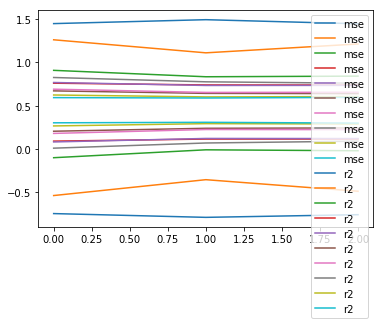

In [114]:
plt.plot(MSE, label="mse")
# plt.plot(testScore, label="score")
plt.plot(rScore, label="r2")
# plt.plot(EV, label="ev")
plt.legend(loc='upper right')
plt.show()

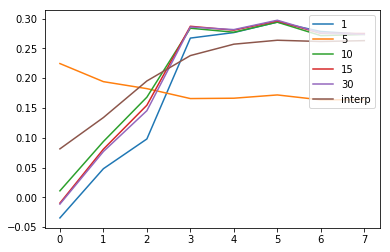

In [25]:
one = np.load('onehzr2.npy')
five = np.load('fivehzr2.npy')
ten = np.load('tenhzr2.npy')
fif = np.load('fifhzr2.npy')
thirty = np.load('thirtyhzr2.npy')
plt.plot(one[2:], label="1")
plt.plot(five[2:], label="5")
plt.plot(ten[2:], label="10")
plt.plot(fif[2:], label="15")
plt.plot(thirty[2:], label="30")
plt.plot(interphzr[2:], label= "interp")
plt.legend(loc='upper right')
plt.show()

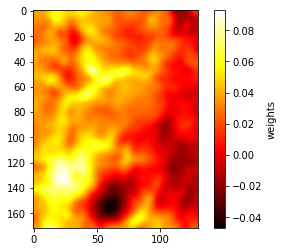

In [17]:
#["stimType", "intensity", "wheelPeri", 'responseT', 'response','whiskPeri', 'lastStimT', 'pupilMovement', 'vidPeri']
#stim type
imc = plt.imshow((avgCoef[0]).reshape(172,130), cmap='hot', interpolation='gaussian')
plt.colorbar(label='weights')

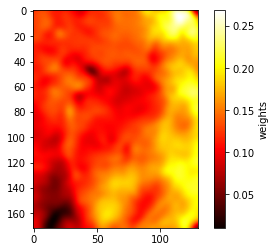

In [18]:
#intensity
imc = plt.imshow((avgCoef[1]).reshape(172,130), cmap='hot', interpolation='gaussian')
plt.colorbar(label='weights')

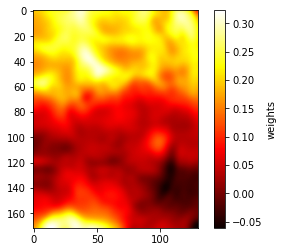

In [19]:
#wheel
imc = plt.imshow((avgCoef[2]).reshape(172,130), cmap='hot', interpolation='gaussian')
plt.colorbar(label='weights')

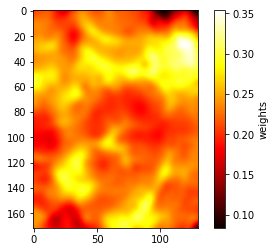

In [20]:
#response time
imc = plt.imshow((avgCoef[3]).reshape(172,130), cmap='hot', interpolation='gaussian')
plt.colorbar(label='weights')

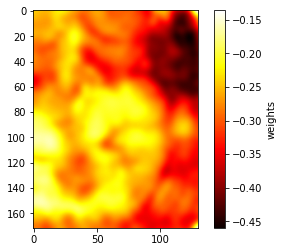

In [21]:
#response
imc = plt.imshow((avgCoef[4]).reshape(172,130), cmap='hot', interpolation='gaussian')
plt.colorbar(label='weights')

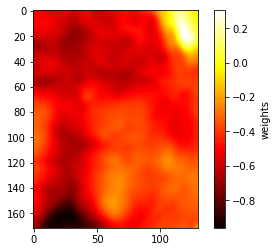

In [22]:
#whisk
imc = plt.imshow((avgCoef[5]).reshape(172,130), cmap='hot', interpolation='gaussian')
plt.colorbar(label='weights')

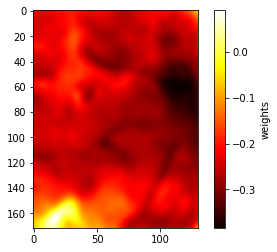

In [23]:
#last stim time
imc = plt.imshow((avgCoef[6]).reshape(172,130), cmap='hot', interpolation='gaussian')
plt.colorbar(label='weights')

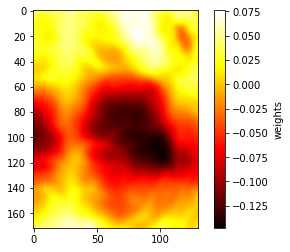

In [24]:
#'pupilMovement'
imc = plt.imshow((avgCoef[7]).reshape(172,130), cmap='hot', interpolation='gaussian')
plt.colorbar(label='weights')

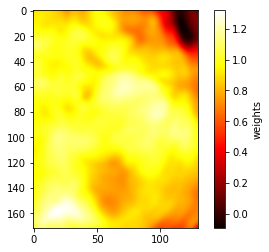

In [25]:
#vidPeri
imc = plt.imshow((avgCoef[8]).reshape(172,130), cmap='hot', interpolation='gaussian')
plt.colorbar(label='weights')

In [34]:
def r2_keras(y_true, y_pred):
    SS_res =  np.sum(np.square(np.subtract(y_true,y_pred))) 
    SS_tot = np.sum(np.square(np.subtract(y_true, np.mean(y_true)))) 
    return ( 1 - SS_res/(SS_tot))

In [105]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = df_scaled
        y_true = dy
    else:
        # Use test-data.
        x = df_test
        y_true = dy_test 
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    sum_pred = []
    sum_true = []
    # Use the model to predict the output-signals.
    y_pred = predTifModel.predict(x[0])
    print(y_true)
    plt.figure(figsize=(15,5))
    for i in range(len(x[0])):
        sum_pred.append(np.sum(y_pred[i])/(lenx*leny))
        sum_true.append(np.sum(y_true[i])/(lenx*leny))
    # Plot and compare the two signals.
    plt.plot(sum_true, label='true')
    plt.plot(sum_pred, label='pred')
    print("r2")
    print(r2_keras(y_true, y_pred))
    print("ev")
    print(explained_variance_score(y_true, y_pred))

    # Plot labels etc.
    plt.ylabel("sum")
    plt.legend()
    plt.show()

[[-0.6982679   0.8388257   1.2394861  ...  0.3828918  -0.4731558
   0.15229397]
 [-1.4745344   0.3173077   1.0070715  ...  2.045574   -0.5288756
   0.5461046 ]
 [-1.7171177  -0.16944243 -0.24796757 ...  0.77085096 -0.5288756
  -0.29777536]
 ...
 [-0.40716797 -0.795264   -0.94521147 ...  0.2166236   0.9198392
  -0.01648203]
 [ 0.999815   -0.23897816  0.9141056  ... -0.00506734  0.52980065
   0.20855263]
 [-0.06755139 -0.65619254 -1.1079017  ... -1.1689448  -0.974634
   0.15229397]]
r2
0.35625873383384754
ev
0.4078229539536379


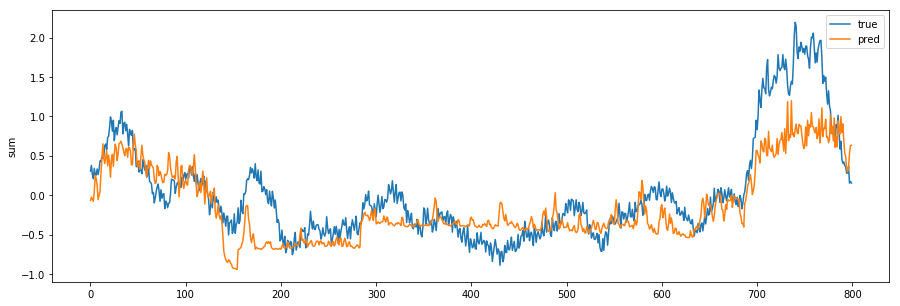

In [106]:
plot_comparison(start_idx=0, length=800, train=False)

In [53]:
%matplotlib inline
def plot_image_difference(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = df_scaled
        y_true = dy
    else:
        # Use test-data.
        x = df_scaled
        y_true = dy 
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x.iloc[start_idx]
    y_true = y_true[start_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    print(x)

    # Use the model to predict the output-signals.
    y_pred = predTifModel.predict(x)
    plt.figure(figsize=(15,5))
    imc = plt.imshow((np.subtract(y_true, y_pred[0])).reshape(172,130), cmap='hot', interpolation='gaussian')
    plt.colorbar(label='difference')
    print("r2")
    print(explained_variance_score(y_true, y_pred[0]))

    plt.legend()
    plt.show()
    plt.figure(figsize=(15,5))
    imc = plt.imshow((y_pred[0]).reshape(172,130), cmap='hot', interpolation='gaussian')
    plt.colorbar(label='pred')


    plt.legend()
    plt.show()

    plt.figure(figsize=(15,5))
    imc = plt.imshow((y_true).reshape(172,130), cmap='hot', interpolation='gaussian')
    plt.colorbar(label='true')


    plt.legend()
    plt.show()

No handles with labels found to put in legend.


[[ 0.6850703   1.24838649 -0.4458782  -0.76012035 -0.80965573  0.74681496
  -1.04219141 -0.35446221 -0.03017694]]
r2
0.3737396674405662


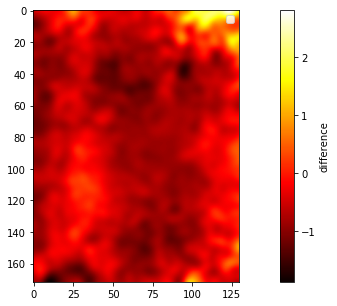

No handles with labels found to put in legend.


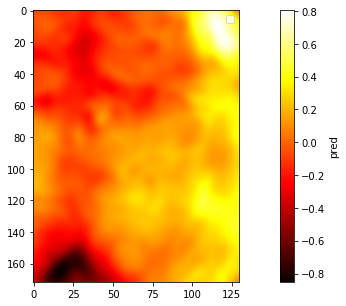

No handles with labels found to put in legend.


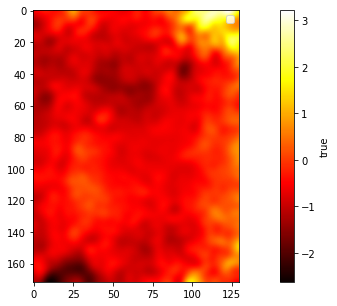

In [54]:
plot_image_difference(start_idx=1, length=4000, train=False)